In [48]:
# @title
from IPython.display import HTML
shell = get_ipython()

def adjust_font_size():
  display(HTML('''<style>
    body {
      font-size: 18px;
    }
  '''))

if adjust_font_size not in shell.events.callbacks['pre_execute']:
  shell.events.register('pre_execute', adjust_font_size)


# Simple Convolution Neural Network (CNN) in JAX, Flax


## What is JAX/Flax?

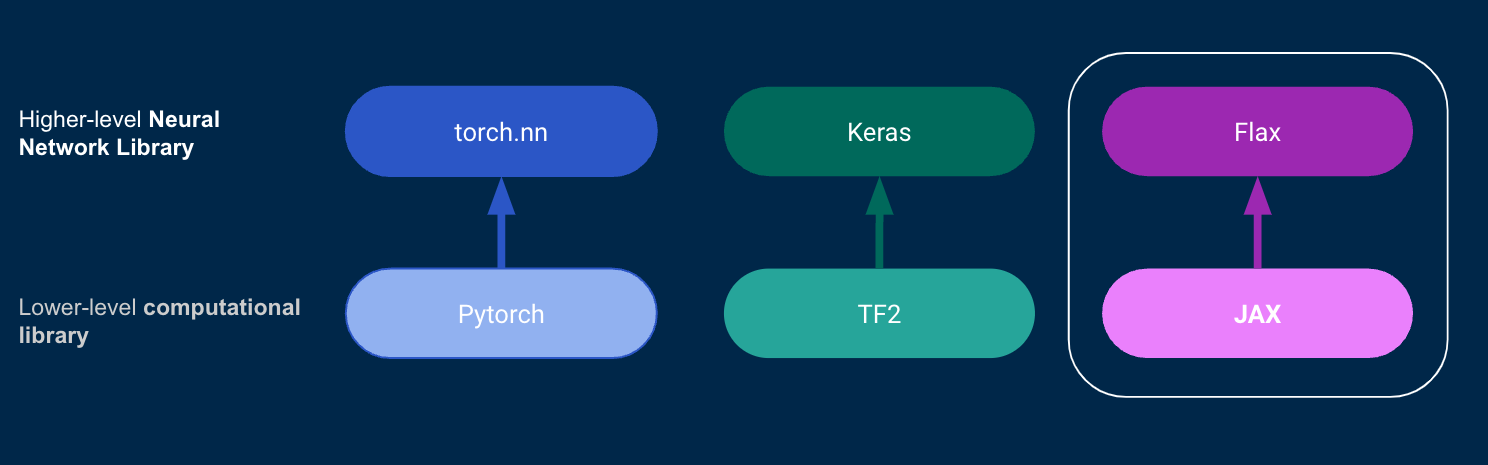

## We'll build a CNN to classify MNIST digits using JAX, Flax!

In [49]:
import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.training import train_state  # Useful dataclass to keep train state
import optax

## Dataset pipline

In [50]:
import tensorflow as tf

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize the pixel values.
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert the labels to one-hot encoding.
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [51]:
def create_dataset(input_image_tensors, label_tensors):
  dataset = (
      tf.data.Dataset
      .from_tensor_slices((input_image_tensors, label_tensors))
      .shuffle(buffer_size=5000)
      .batch(64)
      .repeat()
      .prefetch(tf.data.AUTOTUNE)
      .as_numpy_iterator())
  return dataset

def get_batch(dataset):
  images, labels = next(dataset)
  images, labels = jnp.array(images), jnp.array(labels, dtype=jnp.int32)
  images = jnp.expand_dims(images, axis=-1)
  return images, labels

In [52]:
# Create a tf.data pipeline for the train and test set.
train_dataset = create_dataset(x_train, y_train)
test_dataset = create_dataset(x_test, y_test)

### Let's test fetching a batch...

In [53]:
images_batch, labels_batch = get_batch(train_dataset)
single_image, single_label = images_batch[0], labels_batch[0]

In [54]:
single_label

Array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int32)

## Modeling

In [55]:
import flax.linen as nn

class Model(nn.Module):
  def setup(self):
    # 28x28x1 -> 14x14x16
    self.conv1 =  nn.Conv(16, kernel_size=(3, 3), strides=(2, 2))

    # 14x14x16 -> 7x7x8
    self.conv2 = nn.Conv(8, kernel_size=(3, 3), strides=(2, 2))

    # 7x7x8 -> 4x4x4
    self.conv3 = nn.Conv(4, kernel_size=(3, 3), strides=(2, 2))

    # 4x4x4 -> 2x2x1
    self.conv4 = nn.Conv(1, kernel_size=(3, 3), strides=(2, 2))

    self.final_layer = nn.Dense(10)

  def __call__(self, x):
    x = nn.relu(self.conv1(x))
    x = nn.relu(self.conv2(x))
    x = nn.relu(self.conv3(x))
    x = nn.relu(self.conv4(x))

    # flatten
    batch_size = x.shape[0]
    x = x.reshape(batch_size, -1)

    x = self.final_layer(x)
    return x

## How to implement training Loop in Flax


In [56]:
# JAX functions need to be **state-less!

In [57]:
# Initialize the model using `model.init`, the function returns the model params.
model = Model()
params = model.init(jax.random.PRNGKey(99), images_batch)
params = params["params"]

In [58]:
# @title
params

{'conv1': {'kernel': Array([[[[ 0.10318059, -0.36546168,  0.10348582, -0.18727979,
            -0.2989344 , -0.06120202, -0.30305564, -0.06325838,
            -0.47007623,  0.00182239,  0.08036909, -0.28868243,
            -0.1755667 , -0.46929264,  0.22673424,  0.1213199 ]],
  
          [[-0.00159304, -0.06865791, -0.48096153,  0.5176608 ,
            -0.24610692,  0.12146369,  0.31982005,  0.19794294,
            -0.4636128 ,  0.13819885, -0.17930195,  0.1044026 ,
            -0.54910463,  0.4998827 , -0.33488676,  0.5588218 ]],
  
          [[-0.01486812, -0.27757135,  0.65702665, -0.28058687,
            -0.37632743,  0.06171224,  0.63409156,  0.1940167 ,
             0.55188036,  0.35217246, -0.39919505, -0.42158285,
            -0.2778281 , -0.01271519, -0.72809803, -0.5164525 ]]],
  
  
         [[[ 0.05771004, -0.03288956, -0.14206718, -0.3323581 ,
            -0.17923449,  0.18122466,  0.72265977,  0.53838944,
            -0.19212681,  0.2795688 , -0.23983324,  0.0612007 ,
  

# Forward Pass in JAX

In [59]:
logits = model.apply({"params": params}, images_batch)

In [60]:
logits.shape

(64, 10)

## putting everything together into a concise forward pass function...

In [61]:
# Use TrainState to store all the state required during training.

In [62]:
state = train_state.TrainState.create(
    apply_fn=model.apply,  # forward pass func
    params=params,   # model weights
    tx=optax.adam(learning_rate=0.001)  # optimizer func
)

In [63]:
def forward_pass(params, state, batch):
  input_images, labels = batch

  # call forward pass function.
  logits = state.apply_fn({"params": params}, input_images)

  # compute loss
  loss = optax.softmax_cross_entropy(logits=logits, labels=labels)
  loss = loss.mean()
  return loss, logits

# Backward Pass in JAX

In [64]:
# First, we need to create a function to compute gradients.

In [65]:
# `argnums=(0)` says differentiate wrt 0th pos argument.

grad_fn = jax.grad(forward_pass, argnums=(0), has_aux=True)

In [66]:
grads, _ = grad_fn(state.params, state, (images_batch, labels_batch))

In [67]:
# Let's look at the grads.

In [68]:
grads

{'conv1': {'bias': Array([-0.00420862,  0.00498522, -0.00124551, -0.00252362, -0.00011747,
         -0.00958637, -0.00894821,  0.0035512 ,  0.00267094,  0.00329055,
         -0.00200651, -0.00324172,  0.00064485, -0.00531836, -0.00432093,
          0.0001647 ], dtype=float32),
  'kernel': Array([[[[ 5.90112293e-04, -3.81505706e-05, -3.84123484e-03,
            -7.90453341e-04,  0.00000000e+00, -5.05380984e-03,
            -5.22272661e-03,  5.53828198e-03,  3.26428592e-04,
             2.27951934e-03, -6.29801536e-04,  1.06204359e-03,
            -3.08036542e-05, -9.46768909e-04, -1.67114823e-03,
             7.27786857e-04]],
  
          [[ 1.82456349e-03,  3.80670652e-04, -6.60727848e-04,
            -9.78617463e-04,  0.00000000e+00, -7.02173403e-03,
            -6.42131362e-03,  2.59360904e-03, -7.51035695e-05,
             1.58158736e-03, -9.96585004e-06,  1.27927633e-03,
            -1.06821335e-05, -1.62353762e-03, -7.49851053e-04,
            -3.42116156e-03]],
  
          [[ 2

In [69]:
# To apply gradients, multiply grad * learning rate and subtract from model params.

In [70]:
# But we can just use the Flax's state.apply_gradients function to do so.

In [71]:
new_state = state.apply_gradients(grads=grads)

In [72]:
new_state

TrainState(step=1, apply_fn=<bound method Module.apply of Model()>, params={'conv1': {'bias': Array([ 0.00099999, -0.00099999,  0.00099999,  0.00099999,  0.00099991,
        0.00099999,  0.00099999, -0.00099999, -0.00099999, -0.00099999,
        0.00099999,  0.00099999, -0.00099998,  0.00099999,  0.00099999,
       -0.00099993], dtype=float32), 'kernel': Array([[[[ 0.10218061, -0.36446196,  0.1044858 , -0.1862798 ,
          -0.2989344 , -0.06020203, -0.30205566, -0.06425837,
          -0.4710762 ,  0.0008224 ,  0.08136907, -0.28968242,
          -0.17456703, -0.46829265,  0.22773422,  0.12031992]],

        [[-0.00259303, -0.06965788, -0.47996154,  0.5186608 ,
          -0.24610692,  0.12246368,  0.32082003,  0.19694296,
          -0.46261293,  0.13719887, -0.17830296,  0.10340261,
          -0.5481056 ,  0.5008827 , -0.33388677,  0.5598218 ]],

        [[-0.01586811, -0.27857134,  0.6560268 , -0.27958688,
          -0.37532756,  0.06271223,  0.63509154,  0.19301672,
           0.5508

## putting everything together into a backward pass function...

In [73]:
def backward_pass(state, batch):
  grad_fn = jax.value_and_grad(forward_pass, argnums=(0), has_aux=True)
  (loss, _), grads = grad_fn(state.params, state, batch)
  state = state.apply_gradients(grads=grads)
  return state, loss

# Finally, we package forward_pass and backward_pass functions into a train_step and eval_step funciton

In [74]:
def train_step(state, batch):
  return backward_pass(state, batch)

In [75]:
def eval_step(state, batch):
  _, labels = batch

  # do forward pass.
  loss, logits = forward_pass(state.params, state, batch)

  # calculate accuracy of prediction over eval dataset.
  pred_labels = jnp.argmax(nn.softmax(logits), axis=-1)

  labels = jnp.argmax(labels, axis=-1)
  acc = jnp.mean(labels == pred_labels)

  return loss, acc

In [76]:
# Train for 1000 steps
for step in range(1):
  train_batch = get_batch(train_dataset)

  state, loss = train_step(state, train_batch)
  if step%100==0:
    eval_batch = get_batch(test_dataset)
    eval_loss, eval_acc = eval_step(state, eval_batch)
    print("train_loss:", loss, "\teval loss:", eval_loss, "\teval acc:", eval_acc*100)

train_loss: 2.3001738 	eval loss: 2.2921026 	eval acc: 14.0625
